# ECBM4040  Assignment 1, Task 2: Multilayer Perceptron (MLP)
This is the second part of the assignment. You will get to know the basic fully connected neural network.

In [44]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt

from ecbm4040.cifar_utils import load_data
try:
    import _pickle as pickle
except ImportError:
    import pickle as pickle



# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [45]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 3072) (1000, 3072) (10000, 3072) (100, 3072)
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)
Development data shape: (100, 3072)
Development data shape (100,)


## Part 1: Basic layers

### Create basic layer functions

<span style="color:red"><strong>TODO</strong></span>: Complete functions **affine_forward**, **affine_backward** in **./ecbm4040/layer_funcs.py**.

In [7]:
from ecbm4040.layer_funcs import affine_forward
from ecbm4040.layer_funcs import affine_backward

# generate data for checking
x = X_dev
w = np.random.rand(x.shape[1],100)
b = np.random.rand(100)
dout = np.ones((x.shape[0],100))

# Affine function -- H = W*X + b
out = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, x, w, b)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

# Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **relu_forward**, **relu_backward** in **./ecbm4040/layer_funcs.py**.

In [32]:
from ecbm4040.layer_funcs import relu_forward
from ecbm4040.layer_funcs import relu_backward

# Activation layers -- Here we introduce ReLU/Leaky ReLU activation functions
# since they are the most commonly used in computer vision problems.
# However, you can also try to implement other activation functions like sigmoid, tanh etc. 
x = X_dev
dout = np.ones(x.shape)
# ReLU
out = relu_forward(x)
dx = relu_backward(dout, x)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
out_tf = tf.nn.relu(x_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)[0]
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check = sess.run(dx_tf)

# Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **softmax_loss** in **./ecbm4040/layer_funcs.py**

In [33]:
from ecbm4040.layer_funcs import softmax_loss

# generate some random data for testing
x = np.random.rand(100,10)
y = np.argmax(x, axis=1)

loss, dx = softmax_loss(x, y)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# tensorflow gradients
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
y_tf = tf.Variable(y, name='y')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= x_tf, labels=tf.one_hot(y_tf,10))
loss_tf = tf.reduce_mean(cross_entropy)
dx_tf = tf.gradients(loss, x)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(loss_tf, x_tf)
with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf)
    dx_check = sess.run(dx_tf)

# Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is loss correct? True
Is dx correct? True


### Create a single layer

Now try to combine an affine function and a nonlinear activation function into a single fully-connected layer. Edit the code in ./ecbm4040/layer_utils.py

$$\mathbf{O} = activation(\mathbf{W} \times \mathbf{X} + \mathbf{b})$$

For this assignment, you need to create two types of layers as below. You can get started with the skeleton code in ./ecbm4040/layer_utils.py. The basic class structure has been provided, and you need to fill in the "TODO" part(s). 

* DenseLayer -- Affine transform >> ReLU
```
Class DenseLayer:
    Variables: weights, bias 
    Functions: 
        __init__: given (input_dim, output_dim, weight_scale)
        feedforward: TODO
        backforward: TODO      
```    
* AffineLayer -- Affine transform >> Softmax and the class structure is similar to DenseLayer

<span style="color:red"><strong>TODO</strong></span>: Complete function **DenseLayer** in **./ecbm4040/layer_utils.py**

In [34]:
# First, let's make a dense layer
from ecbm4040.layer_utils import DenseLayer

# Affine + ReLU
test_dense = DenseLayer(input_dim=3072,output_dim=100)
w, b = test_dense.params

# Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_dense.feedforward(x)
dx = test_dense.backward(dout)
dw, db = test_dense.gradients

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.nn.relu(tf.matmul(x_tf,w_tf) + b_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

# Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete function **AffineLayer** in **./ecbm4040/layer_utils.py**

In [35]:
from ecbm4040.layer_utils import AffineLayer

# Affine + ReLU
test_affine = AffineLayer(input_dim=3072,output_dim=100)
w, b = test_affine.params

# Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_affine.feedforward(x)
dx = test_affine.backward(dout)
dw, db = test_affine.gradients

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


## Part 2: More Backpropogation

Complete the class **TwoLayerNet** in **./ecbm4040/classifiers/twolayernet.py**. Through this experiment, you will create a two-layer neural network and learn about the backpropagation mechanism. The network structure is like **input >> DenseLayer >> AffineLayer >> softmax loss >> output**. Complete "TODO" part(s).
```
Class TwoLayerNet:   
    Functions: 
        __init__: GIVEN
        loss: TODO - calculate cross entropy loss and gradients wst all weights and bias.
        step: TODO - a single update all weights and bias by SGD.
        predict: TODO - output result(classification accuracy) based on input data
    
    Variables:
        layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete class **TwoLayerNet** in **./ecbm4040/classifiers/twolayernet.py**

In [36]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet

# Define a model
model = TwoLayerNet(input_dim=3072, hidden_dim=200, num_classes=10, reg=1e-5)
W1, b1 = model.layer1.params
W2, b2 = model.layer2.params
## Backprogation -- Finish loss function and gradients calculation in TwoLayerNet
loss = model.loss(X_dev, y_dev)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
# Check loss by tensorflow
x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.uint8, shape=(None,))

W1_tf = tf.Variable(W1.astype('float32'))
b1_tf = tf.Variable(b1.astype('float32'))
W2_tf = tf.Variable(W2.astype('float32'))
b2_tf = tf.Variable(b2.astype('float32'))
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + 1e-5*L2_loss 
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf, feed_dict={x_tf: X_dev, y_tf: y_dev})
    
# Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))



Is loss correct? True


### Train a two-layer network

#### Import functions for training and testing

In [46]:
from ecbm4040.train_funcs import train, test

#### Start training
<span style="color:red"><strong>TODO</strong></span>: Use previous layers to create a two layer neural network:

**input->(affine->activation)->(affine->softmax)->output**

The recommended activation function is ReLU. You can also make a comparison with other activation function to see any difference.

In [39]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet


model = TwoLayerNet(input_dim=3072, hidden_dim=150, num_classes=10, reg=0.5, weight_scale=1e-1)

num_epoch = 15
batch_size = 300
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)

test(model, X_test, y_test)

number of batches for training: 163
epoch 1: valid acc = 0.134, new learning rate = 0.00095
epoch 2: valid acc = 0.186, new learning rate = 0.0009025
epoch 3: valid acc = 0.188, new learning rate = 0.000857375
epoch 4: valid acc = 0.227, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.266, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.276, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.292, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.324, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.352, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.366, new learning rate = 0.0005987369392383785
epoch 11: valid acc = 0.378, new learning rate = 0.0005688000922764595
epoch 12: valid acc = 0.385, new learning rate = 0.0005403600876626365
epoch 13: valid acc = 0.394, new learning rate = 0.0005133420832795047
epoch 14: valid acc = 0.421, new learning rate = 0.00048767497911552944
epoch 15: valid

0.44290000000000002

<span style="color:red"><strong>TODO</strong></span>: Plot training and validation accuracy history of each epoch

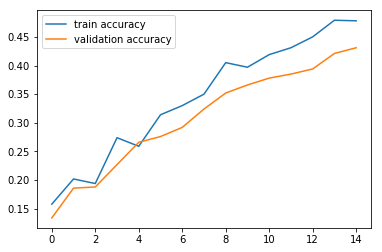

In [40]:
# plot the accuracy history
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

#### Visulize the weight variable in the first layer.

Visualization of the intermediate weights can help you get an intuitive understanding of how the network works, especially in  Convolutional Neural Networks (CNNs).

In [76]:
from ecbm4040.display_funcs import visualize_pics

num of feature vectors: 150


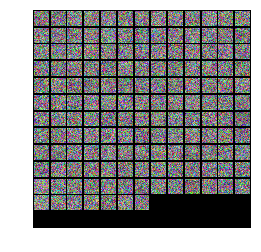

In [42]:
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
# visualization
visualize_pics(pics)

### Get test accuracy greater than 48%

For this part, you need to train a better two-layer net. The requirement is to get test accuracy better than 48%. If your accuracy is lower, for each 1% lower than 48%, you will lose 1 point. On the other hand, you will get one extra point for every 1% higher than 52%.

Here are some recommended methods for improving the performance. Feel free to try any other method as you see fit.

1. Hyperparameter tuning: reg, hidden_dim, lr, learning_decay, num_epoch, batch_size, weight_scale.
2. Adjust training strategy: Randomly select a batch of samples rather than selecting them orderly. 
3. Try new optimization methods: Now we are using SGD, you can try SGD with momentum, adam, etc. For example, if you change SGD into SGD with momentum, then you should get about 2% increase in accuracy.
4. Early-stopping.
5. Good (better) initial values for weights in the model.
6. Try use PCA or other preprocessing methods. (Try task3-dim_reduction.ipynb before finishing this task)

A comparison between SGD and SGD with momentum.

* Stochastic gradient descent - SGD
    ```
    w = w - learning_rate * gradient 
    ```
* SGD with momentum
    ```
    v = momentum*v + learning_rate * gradient
    w = w - v
    ```
    
<span style="color:red"><strong>TODO</strong></span>: See below

In [97]:
# TODO
#  from ecbm4040.classifiers.twolayernet import TwoLayerNet

# TODO: Use previous layers to create a two layer neural network.
# Try several solutions and report the best performing one.
# input->(affine->activation)->(affine->softmax)->output
# The recommended activation function is ReLU. You can 
# make a comparison with other activation functions to see
# the differences.
#
# You will need to execute code similar to below, using your parameter specs:
#    model = TwoLayerNet(input_dim=TBD, hidden_dim=TBD, num_classes=TBD, reg=TBD, weight_scale=TBD)
#    num_epoch = TBD
#    batch_size = TBD
#    lr = TBD
#    verbose = TBD
#    train_acc_hist, val_acc_hist = train(TBD)
#    test(TBD, TBD, TBD)

from ecbm4040.classifiers.ss5116_twolayernet import ss5116_TwoLayerNet
from ecbm4040.features.pca import pca_naive

K = 100 # number of principal components
X = np.concatenate((X_train,X_val,X_test))
X = np.reshape(X,[X.shape[0],-1])
P,T = pca_naive(X,K)
PCA = np.dot(X,np.transpose(P))

PCA_train = PCA[:49000,:]
PCA_val= PCA[49000:50000,:]
PCA_test=PCA[50000:,:]

model_1 = ss5116_TwoLayerNet(input_dim=PCA_train.shape[1], hidden_dim=100, num_classes=10, reg=0.05, weight_scale=1e-2)

num_epoch = 20
batch_size = 100
lr = 9e-4
verbose = 0
train_accuracy, val_accuracy = train(model_1, PCA_train, y_train, PCA_val, y_val, num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)

test_accuracy=test(model_1, PCA_test, y_test)


number of batches for training: 490
epoch 1: valid acc = 0.429, new learning rate = 0.000855
epoch 2: valid acc = 0.472, new learning rate = 0.0008122499999999999
epoch 3: valid acc = 0.475, new learning rate = 0.0007716374999999999
epoch 4: valid acc = 0.474, new learning rate = 0.0007330556249999998
epoch 5: valid acc = 0.486, new learning rate = 0.0006964028437499998
epoch 6: valid acc = 0.485, new learning rate = 0.0006615827015624998
epoch 7: valid acc = 0.498, new learning rate = 0.0006285035664843748
epoch 8: valid acc = 0.503, new learning rate = 0.000597078388160156
epoch 9: valid acc = 0.503, new learning rate = 0.0005672244687521483
epoch 10: valid acc = 0.51, new learning rate = 0.0005388632453145408
epoch 11: valid acc = 0.511, new learning rate = 0.0005119200830488137
epoch 12: valid acc = 0.51, new learning rate = 0.000486324078896373
epoch 13: valid acc = 0.504, new learning rate = 0.0004620078749515543
epoch 14: valid acc = 0.504, new learning rate = 0.0004389074812039

#### <span style="color:red"><strong>TODO</strong></span>: Show your best result, including accuracy and weights of the first layer

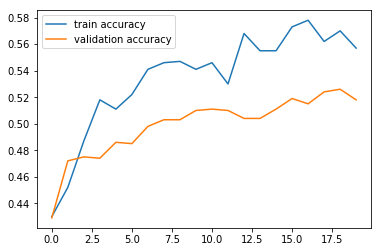

In [98]:

# TODO: plot training and validation accuracy

plt.plot(train_accuracy, label="train accuracy")
plt.plot(val_accuracy, label="validation accuracy")
plt.legend()
plt.show()

num of feature vectors: 100


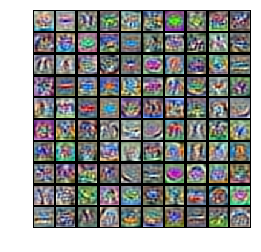

In [99]:
# TODO: Visualize weights
weights = model_1.layer1.params[0]
weights = np.dot(np.transpose(P),weights)
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
# visualization
visualize_pics(pics)

### Save your best model in a dictionary 

In [100]:
# Create "save_model" folder if it does not exist
save_dir = "./save_models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save your model
save_params = model_1.save_model()
with open("./save_models/best_model.pkl", "wb") as output_file:
    pickle.dump(save_params, output_file)

In [101]:
# Load your model
with open("./save_models/best_model.pkl", "rb") as input_file:
    load_params = pickle.load(input_file)
    
model_1.update_model(load_params)

## Part 3: Multilayer Net 

Complete the class **MLP** in **./ecbm4040/classifiers/network.py**. It should allow arbitrary settings for the number of hidden layers as well as the number of hidden neurons in each layer. **MLP** has a similar structure as a **TwoLayerNet** network. Complete the "<span style="color:red"><strong>TODO</strong></span>" part.

```
class MLP:
    functions: __init__, loss, step, predict, check_accuracy
    variables: layers
```

In [59]:
from ecbm4040.classifiers.mlp import MLP

# TODO: Use a sequence of layers to create a multiple layer neural network
# input->(affine->activation)-> ... ->(affine->activation)->(affine->softmax)->output
model = MLP(input_dim=3072, hidden_dims=[100, 50], num_classes=10, reg=0.25, weight_scale=1e-1)

num_epoch = 20
batch_size = 100
lr = 1e-2
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 490
epoch 1: valid acc = 0.293, new learning rate = 0.0095
epoch 2: valid acc = 0.322, new learning rate = 0.009025
epoch 3: valid acc = 0.323, new learning rate = 0.00857375
epoch 4: valid acc = 0.328, new learning rate = 0.0081450625
epoch 5: valid acc = 0.328, new learning rate = 0.007737809374999999
epoch 6: valid acc = 0.331, new learning rate = 0.007350918906249998
epoch 7: valid acc = 0.336, new learning rate = 0.006983372960937498
epoch 8: valid acc = 0.338, new learning rate = 0.006634204312890623
epoch 9: valid acc = 0.335, new learning rate = 0.006302494097246091
epoch 10: valid acc = 0.336, new learning rate = 0.005987369392383786
epoch 11: valid acc = 0.341, new learning rate = 0.005688000922764597
epoch 12: valid acc = 0.335, new learning rate = 0.005403600876626367
epoch 13: valid acc = 0.336, new learning rate = 0.005133420832795048
epoch 14: valid acc = 0.345, new learning rate = 0.0048767497911552955
epoch 15: valid acc = 0.339, new lea

0.34339999999999998

## Part 4: Tensorflow MLP
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net. You need to implement a multi-layer with 3 or 4 layers.

In [33]:
# Demo: Two-layer net in tensorflow.
hidden_dim = 100
reg_tf = tf.constant(0.01)

x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.int64, shape=(None,))

W1_tf = tf.Variable(1e-2*np.random.rand(3072, hidden_dim).astype('float32'))
b1_tf = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
W2_tf = tf.Variable(1e-2*np.random.rand(hidden_dim, 10).astype('float32'))
b2_tf = tf.Variable(np.zeros((10,)).astype('float32'))

h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 

init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(h2_tf,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(10):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.23499999940395355
epoch 2: valid acc = 0.3310000002384186
epoch 3: valid acc = 0.34199997782707214
epoch 4: valid acc = 0.3709999620914459
epoch 5: valid acc = 0.3930000066757202
epoch 6: valid acc = 0.39800000190734863
epoch 7: valid acc = 0.42399999499320984
epoch 8: valid acc = 0.4320000112056732
epoch 9: valid acc = 0.4439999759197235
epoch 10: valid acc = 0.44599997997283936
test acc = 0.44599997997283936


<span style="color:red"><strong>TODO</strong></span>: Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" or "dictionary" to store your network parameters, ie., weights and bias. Besides, consider to use a loop to create your MLP network.

In [34]:
# For example
#weights = {
#    'w1': tf.Variable(),
#    'w2': tf.Variable()),
#    'w3': tf.Variable()),
#    'w4': tf.Variable()),
#    ...
#}

In [60]:
hidden_dims_m=[100,25]
reg_tf_m=tf.constant(5e-2)
wt_tf_m=tf.constant(1.e-2)

X_tf_m=tf.placeholder(tf.float32, shape=(None,X_train.shape[1]))
y_tf_m=tf.placeholder(tf.int64,shape=(None,))
W_m=[]
b_m=[]
layers=len(hidden_dims_m)


hidden_dims_m.insert(0,X_train.shape[1])
hidden_dims_m.append(np.max(y_train)+1)


for i in range(layers+1):
    W_m.append(tf.Variable(wt_tf_m*np.random.rand(hidden_dims_m[i], hidden_dims_m[i+1]).astype('float32')))
    b_m.append(tf.Variable(np.zeros(hidden_dims_m[i+1],).astype('float32')))
    
h_m=[]
h_m.append(X_tf_m)
for i in range(layers):
    h_m.append(tf.nn.relu(tf.matmul(h_m[i],W_m[i])+b_m[i]))
h_m[layers]= tf.matmul(h_m[layers], W_m[layers]) + b_m[layers]    


cross_entropy_m=tf.nn.softmax_cross_entropy_with_logits(logits= h_m[layers], labels=tf.one_hot(y_tf_m,np.max(y_train)+1))
L2_loss_m=tf.nn.l2_loss(np.zeros(1).astype('float32'))


for i in range(layers+1):
    L2_loss_m+=tf.nn.l2_loss(W_m[i])
loss_tf_m=tf.reduce_mean(L2_loss_m)+reg_tf_m*L2_loss_m

lr=tf.constant(1e-2)


init_m = tf.global_variables_initializer()
train_step_m = tf.train.GradientDescentOptimizer(lr).minimize(loss_tf_m)
correct_prediction_m = tf.equal(y_tf_m, tf.argmax(h_m[layers],1))
accuracy_m = tf.reduce_mean(tf.cast(correct_prediction_m, tf.float32))


batch_size_m = 300
num_batch_m = X_train.shape[0]//batch_size
epochs=20
with tf.Session() as sess:
    sess.run(init_m)
    for e in range(epochs):
        for i in range(num_batch_m):
            X_batch_m, y_batch_m = X_train[i*batch_size_m:(i+1)*batch_size_m], y_train[i*batch_size_m:(i+1)*batch_size_m]
            sess.run(train_step_m, feed_dict={X_tf_m: X_batch_m, y_tf_m: y_batch_m})
        val_acc_m = sess.run(accuracy_m, feed_dict={X_tf_m: X_val, y_tf_m: y_val})
        print('epoch {}: val acc = {}'.format(e+1, val_acc_m))
    
    test_acc_m = sess.run(accuracy_m, feed_dict={X_tf_m: X_val, y_tf_m: y_val})
    print('test acc = {}'.format(test_acc_m))


epoch 1: val acc = 0.07899999618530273
epoch 2: val acc = 0.07899999618530273
epoch 3: val acc = 0.07899999618530273
epoch 4: val acc = 0.07899999618530273
epoch 5: val acc = 0.07899999618530273
epoch 6: val acc = 0.10400000214576721
epoch 7: val acc = 0.10400000214576721
epoch 8: val acc = 0.10400000214576721
epoch 9: val acc = 0.10400000214576721
epoch 10: val acc = 0.10399999469518661
epoch 11: val acc = 0.10399999469518661
epoch 12: val acc = 0.10399999469518661
epoch 13: val acc = 0.10400000214576721
epoch 14: val acc = 0.10399999469518661
epoch 15: val acc = 0.10399999469518661
epoch 16: val acc = 0.10399999469518661
epoch 17: val acc = 0.10400000214576721
epoch 18: val acc = 0.10400000214576721
epoch 19: val acc = 0.10400000214576721
epoch 20: val acc = 0.10399999469518661
test acc = 0.10400000214576721
